In [16]:
import os
import numpy as np
from tqdm import tqdm
import json
import glob
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams["font.family"] = "Palatino"
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

from utils.rl_glue import RLGlue

In [2]:
# some helper functions used by all experiments

def all_files_with_prefix_and_suffix(location, prefix, suffix):
    """returns a list of all files in the 'location' starting with the given prefix"""
    if location[-1] != '/':
        location += '/'
    files = glob.glob(location + prefix + '*' + suffix)

    return files


def plot_all_tl(param_list, item, param2='alpha_w', title=None, firstn=-1, last_from=-1, 
                num_sa=None, logbase=-1, ylabel='RMSVE\n(TVR)', y_lims=(0.21, 0.39),
                out_location=None, final=False):

    data_all = {}
    for location, filename_prefix, param1 in param_list:
    
        files = all_files_with_prefix_and_suffix(location, filename_prefix, '*.npy')
        assert len(files) > 0, 'No files found with the prefix: ' + location + filename_prefix
        print('Filename\t%s\t%s\tValue\n' % (param1, param2))
        for file in files:
            data = np.load(file, allow_pickle=True).item()
            param1_value = data['params']['agent_parameters'][param1]
            if param1=='reference_state' and param1_value==0:
                if data['params']['agent_parameters']['reference_action'] == 1:
                    param1_value = 10
            if param1_value not in data_all:
                data_all[param1_value] = {}
            param2_value = data['params']['agent_parameters'][param2]
            if param2_value not in data_all[param1_value]:
                data_all[param1_value][param2_value] = {}
            assert not (firstn!=-1 and last_from!=-1), "Both firstn and lastn can't be chosen together"
            if firstn != -1:
                data_to_eval = data[item][:,:firstn]
            elif last_from != -1:
                data_to_eval = data[item][:,last_from:]
            else:
                data_to_eval = data[item]
            metric_per_run = np.mean(data_to_eval, axis=1)
            metric = np.mean(metric_per_run)
            metric_stderr = np.std(metric_per_run) / np.sqrt(metric_per_run.size)
            data_all[param1_value][param2_value] = (metric, metric_stderr)
            print('%s\t%s\t%s\t%.3f\t%.3f' % (file[-10:-3], param1_value, param2_value, metric, metric_stderr))

    print(data_all.keys())
    print(data_to_eval.shape[0])
    try: 
        X = sorted(data_all.keys())
    except:
        print('Cannot sort; keys are a mix of numbers and letters')
        X = data_all.keys()
    Y = sorted(data_all[random.choice(list(X))].keys())
    Z_mean = np.zeros((len(X), len(Y)))
    Z_stderr = np.zeros((len(X), len(Y)))
    Z_attrs = ['']*len(X)
    # print(Z_attrs)
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            try:
                Z_mean[i][j] = data_all[x][y][0]
                Z_stderr[i][j] = data_all[x][y][1]
            except:
                Z_mean[i][j] = np.nan
                Z_stderr[i][j] = np.nan
        print(i)
        if x=='max_all_sa':
            Z_attrs[i] = 'dashed'
        elif x=='mean':
            Z_attrs[i] = 'dashdot'
        elif x==0.055 or x==0.011:
            Z_attrs[i] = 'dotted'
        else:
            Z_attrs[i] = 'solid'
    Z_mean = np.ma.masked_invalid(Z_mean)
    Z_stderr = np.ma.masked_invalid(Z_stderr)

    fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

    # colors = ['darkturquoise', 'magenta']
    
    for i, param_value in enumerate(X):
        ax.errorbar(Y, Z_mean[i], yerr=Z_stderr[i], label=str(param_value), linestyle=Z_attrs[i])#, color=colors[i])
    if final!=True:
        ax.legend()
        plt.xlabel(param2)
        plt.ylabel(ylabel, rotation=0, labelpad=40)
        ax.set_title(title)
    if y_lims != None:            # typically (0.21, 0.39) for TC, (2.05, 2.6) for AC, (0, 0.9) for Catcher
        plt.ylim(y_lims[0], y_lims[1])
    ax.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    if logbase != -1:
        ax.set_xscale("log", basex=logbase)
    ax.set_xticks(Y)
    ax.set_xticklabels(Y)
    fig.tight_layout()
    if final==True:
        assert os.path.isfile(out_location + title + '.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(out_location + title + '.png', dpi=1200, transparent=True)
    plt.show()


def plot_learning_curve(files, item='rewards_all_train', window=1000, sample=1, firstn=-1,
                        title=None, h_line=None, out_location=None, final=False):

    fig, ax = plt.subplots(1, 1, figsize=(5.5,4))
    which_step_size = 'alpha_w'
    for location, filename in files:
        data = np.load(location + filename, allow_pickle=True).item()
        rewards_train = data[item][:,:firstn]
        max_run_length = rewards_train.shape[1]
        conv_arr = np.ones(window)
        reward_rate_all = []
        # ToDo: vectorize this
        for run in range(rewards_train.shape[0]):
            reward_rate = np.convolve(rewards_train[run,:], conv_arr, mode='valid') / window
            reward_rate_all.append(reward_rate)
        reward_rate_all = np.array(reward_rate_all)
        mean = np.mean(reward_rate_all, axis=0)
        stderr = np.std(reward_rate_all, axis=0) / np.sqrt(reward_rate_all.shape[0])
        x_s = np.arange(window, max_run_length+1)[::sample]
        y_s = mean[::sample]
        stderr_s = stderr[::sample]
        agent_name = data['params']['agent']
        plt.plot(x_s, y_s, label=agent_name)
        plt.fill_between(x_s, y_s + stderr_s, y_s - stderr_s, alpha=0.3)

    if h_line!= None:
        plt.axhline(y=h_line, color='black', alpha=0.3, linestyle='--')
    plt.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    if not final:
        plt.legend()
        plt.title(title)
    plt.tight_layout()
    if final:
        assert os.path.isfile(out_location + title + '.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(out_location + title + '.png', dpi=1200, transparent=True)
    plt.show()

## A. Control Experiments

### A1: AccessControl

In [ ]:
### To run the experiments with Diff-Q and RVI-Q:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AC_diff-q.json --output-folder results/control/AC
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AC_rvi-q.json --output-folder results/control/AC
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AC_rvi-q_max_all.json --output-folder results/control/AC
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AC_rvi-q_mean.json --output-folder results/control/AC

In [5]:
# some extra helper methods for AccessControl

def read_all_and_return_data(param_list, item, param2='alpha_w', firstn=-1, ref_a_offset=44):

    data_all = {}
    for location, filename_prefix, param1 in param_list:
    
        files = all_files_with_prefix_and_suffix(location, filename_prefix, '*.npy')
        assert len(files) > 0, 'No files found with the prefix: ' + location + filename_prefix
        print('Filename\t%s\t%s\tValue\n' % (param1, param2))
        for file in files:
            data = np.load(file, allow_pickle=True).item()
            param1_value = data['params']['agent_parameters'][param1]
            if param1=='reference_state':
                if data['params']['agent_parameters']['reference_action'] == 1:
                    param1_value += ref_a_offset
            if param1_value not in data_all:
                data_all[param1_value] = {}
            param2_value = data['params']['agent_parameters'][param2]
            if param2_value not in data_all[param1_value]:
                data_all[param1_value][param2_value] = {}
            data_to_eval = data[item][:,:firstn]
            metric_per_run = np.mean(data_to_eval, axis=1)
            metric = np.mean(metric_per_run)
            metric_stderr = np.std(metric_per_run) / np.sqrt(metric_per_run.size)
            data_all[param1_value][param2_value] = (metric, metric_stderr)
            print('%s\t%s\t%s\t%.3f\t%.3f' % (file[-10:-3], param1_value, param2_value, metric, metric_stderr))
    return data_all

def plot_from_data(data_all, ref_sa_list=None, title=None, logbase=10, ylabel=None, y_lims=None, final=False,
                  out_location='./'):
    
    X = sorted(ref_sa_list)
    Y = sorted(data_all[random.choice(list(X))].keys())
    
    Z_mean = np.zeros((len(X), len(Y)))
    Z_stderr = np.zeros((len(X), len(Y)))
    Z_attrs = ['']*len(X)

    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            try:
                Z_mean[i][j] = data_all[x][y][0]
                Z_stderr[i][j] = data_all[x][y][1]
            except:
                Z_mean[i][j] = np.nan
                Z_stderr[i][j] = np.nan
        if x=='max_all_sa':
            Z_attrs[i] = 'dashed'
        elif x=='first_s' or x=='all_ones' or x=='random_bernoulli':
            Z_attrs[i] = 'dashdot'
        elif x=='mean' or x==0.055 or x==0.011:
            Z_attrs[i] = 'dotted'
        else:
            Z_attrs[i] = 'solid'
    Z_mean = np.ma.masked_invalid(Z_mean)
    Z_stderr = np.ma.masked_invalid(Z_stderr)

    fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

    for i, param_value in enumerate(X):
        if param_value in ['all_ones', 'random_bernoulli']:
            continue
        ax.errorbar(Y, Z_mean[i], yerr=Z_stderr[i], label=str(param_value), linestyle=Z_attrs[i])#, color='grey')
    if not final:
        ax.legend()
        # plt.xlabel(r'$\alpha_w$')
        plt.ylabel(ylabel, rotation=0, labelpad=40)
        ax.set_title(title)
    if y_lims != None:            # typically (0.21, 0.39) for TC, (2.05, 2.6) for AC, (0, 0.9) for Catcher
        plt.ylim(y_lims[0], y_lims[1])
    ax.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    if logbase != -1:
        plt.xscale('log', basex=logbase)
    ax.set_xticks(Y)
    ax.set_xticklabels(Y)
    fig.tight_layout()
    if final:
        assert os.path.isfile(out_location + title + '.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(out_location + title + '.png', dpi=1200, transparent=True)
    plt.show()

In [4]:
param_list = [('./results/control/AC/', 'AC_RVIQ_refsa_eps_0.1', 'reference_state')]
data_all_ac_refsa = read_all_and_return_data(param_list, 'rewards_all_train', ref_a_offset=44)

Filename	reference_state	alpha_w	Value

.1_183.	7	0.1	2.539	0.002
.1_360.	59	0.0015625	2.207	0.008
.1_260.	79	0.0015625	2.180	0.010
.1_432.	45	0.025	2.497	0.005
.1_436.	44	0.00625	2.300	0.011
.1_192.	5	0.025	2.536	0.004
_0.1_2.	43	0.025	2.168	0.028
0.1_17.	40	0.025	2.168	0.028
.1_128.	18	0.1	2.468	0.014
.1_355.	60	0.0015625	2.189	0.010
0.1_21.	39	0.00625	2.194	0.019
_0.1_9.	42	0.4	2.150	0.004
.1_328.	66	0.1	2.461	0.023
.1_141.	15	0.00625	2.217	0.016
.1_266.	78	0.00625	2.207	0.013
0.1_25.	38	0.0015625	2.200	0.011
0.1_56.	32	0.00625	2.185	0.022
.1_198.	4	0.1	2.547	0.003
.1_297.	72	0.025	2.173	0.027
.1_415.	48	0.0015625	2.213	0.007
.1_331.	65	0.00625	2.194	0.016
.1_268.	78	0.1	2.184	0.014
.1_166.	10	0.00625	2.281	0.018
.1_258.	80	0.1	2.164	0.012
0.1_68.	30	0.1	2.170	0.017
0.1_23.	39	0.1	2.166	0.017
.1_324.	67	0.4	2.241	0.046
0.1_50.	33	0.0015625	2.204	0.012
.1_320.	67	0.0015625	2.197	0.011
.1_291.	73	0.00625	2.176	0.014
0.1_16.	40	0.00625	2.196	0.019
0.1_72.	29	0.025	2.166	0.029
.1_135.	1

.1_430.	45	0.0015625	2.191	0.011
0.1_84.	27	0.4	2.062	0.024
0.1_99.	24	0.4	2.124	0.012
_0.1_8.	42	0.1	2.168	0.017
.1_424.	47	0.4	1.902	0.032
.1_206.	2	0.00625	2.368	0.010
.1_284.	75	0.4	1.989	0.039
.1_165.	10	0.0015625	2.206	0.013
.1_380.	55	0.0015625	2.341	0.003
.1_411.	49	0.00625	2.386	0.005
.1_421.	47	0.00625	2.425	0.005
.1_344.	63	0.4	2.391	0.004
.1_350.	61	0.0015625	2.203	0.012
.1_301.	71	0.00625	2.159	0.014
.1_306.	70	0.00625	2.195	0.023
.1_186.	6	0.00625	2.376	0.007
.1_111.	21	0.00625	2.205	0.019
.1_145.	14	0.0015625	2.190	0.011
.1_318.	68	0.1	2.233	0.028
.1_363.	59	0.1	2.568	0.003
.1_346.	62	0.00625	2.232	0.013
0.1_55.	32	0.0015625	2.188	0.016
.1_191.	5	0.00625	2.405	0.012
.1_395.	52	0.0015625	2.220	0.009
.1_130.	17	0.0015625	2.206	0.011
.1_233.	85	0.1	2.173	0.017
.1_197.	4	0.025	2.534	0.004
.1_348.	62	0.1	2.546	0.006
.1_310.	69	0.0015625	2.203	0.013
.1_238.	84	0.1	2.166	0.012
.1_354.	61	0.4	2.124	0.030
.1_228.	86	0.1	2.166	0.016
.1_138.	16	0.1	2.482	0.010
.1_311.	69	0.00625	2.

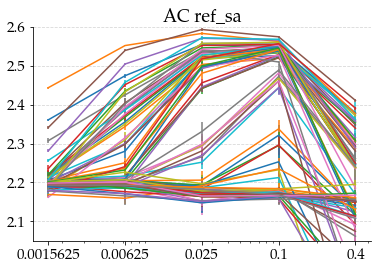

In [6]:
plot_from_data(data_all_ac_refsa, 
               ref_sa_list=range(88), 
               title='AC ref_sa',
               y_lims=(2.05, 2.6), 
               final=False)

Filename	f_type	alpha_w	Value

_0.1_4.	max_all_sa	0.4	2.284	0.023
_0.1_2.	max_all_sa	0.025	2.530	0.003
_0.1_3.	max_all_sa	0.1	2.532	0.004
_0.1_1.	max_all_sa	0.00625	2.471	0.002
_0.1_0.	max_all_sa	0.0015625	2.377	0.002
Filename	eta	alpha_w	Value

_0.1_0.	0.011	0.0015625	2.194	0.012
_0.1_1.	0.011	0.00625	2.289	0.014
_0.1_3.	0.011	0.1	2.547	0.002
_0.1_2.	0.011	0.025	2.494	0.005
_0.1_4.	0.011	0.4	2.463	0.002
dict_keys(['max_all_sa', 0.011])
30
Cannot sort; keys are a mix of numbers and letters
0
1


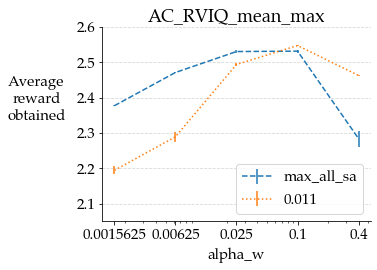

In [43]:
# Used custom colors for these two curves by adding 
# colors = ['darkturquoise', 'magenta'] and using them via colors[i] while plotting

param_list = [
    ('./results/control/AC/', 'AC_RVIQ_maxall_eps_0.1', 'f_type'),
    ('./results/control/AC/', 'AC_RVIQ_mean_eps_0.1', 'eta'),
]

plot_all_tl(param_list, 'rewards_all_train', firstn=-1, ylabel='Average\nreward\nobtained', logbase=10,
            y_lims=(2.05, 2.6), out_location='./results/control/', title='AC_RVIQ_mean_max',
            final=False)

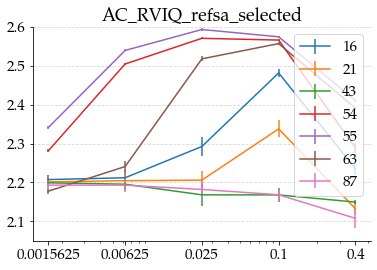

In [6]:
plot_from_data(data_all_ac_refsa, 
               ref_sa_list=[55, 54, 63, 16, 21, 87, 43,], 
               y_lims=(2.05, 2.6), 
               final=False,
               title='AC_RVIQ_refsa_selected',
               out_location='./results/control/')

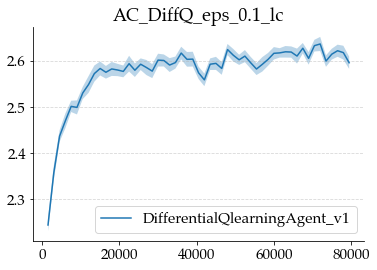

In [42]:
filenames = [
        ('./results_final/control_AC/', "AC_DiffQ_eps_0.1_11-15_0.npy"),  # alpha_w=0.025, eta=0.125
    ]
    
plot_learning_curve(filenames, title='AC_DiffQ_eps_0.1_lc', window=1500, 
                    sample=1500, firstn=-1, out_location='./results/control/AC/', final=False)

### A2: TwoLoop

In [3]:
### To run the experiments with RVI-Q and Diff-Q:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_TC_diff-q.json --output-folder results/control/TwoLoops
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_TC_rvi-q_ref_sa_01.json --output-folder results/control/TwoLoops
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_TC_rvi-q_ref_sa.json --output-folder results/control/TwoLoops
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_TC_rvi-q_max_ref.json --output-folder results/control/TwoLoops
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_TC_rvi-q_mean.json --output-folder results/control/TwoLoops

Filename	reference_state	alpha_w	Value

0.1_58.	10	0.4	0.377	0.001
0.1_48.	8	0.025	0.313	0.010
0.1_49.	8	0.05	0.352	0.006
_0.1_3.	1	0.2	0.347	0.001
0.1_12.	3	0.025	0.210	0.000
0.1_13.	3	0.05	0.268	0.002
_0.1_2.	1	0.1	0.319	0.001
_0.1_0.	1	0.025	0.210	0.000
0.1_39.	6	0.2	0.365	0.004
0.1_10.	2	0.4	0.308	0.003
0.1_38.	6	0.1	0.345	0.004
_0.1_1.	1	0.05	0.259	0.002
0.1_14.	3	0.1	0.298	0.003
0.1_28.	5	0.4	0.370	0.003
0.1_15.	3	0.2	0.313	0.003
_0.1_4.	1	0.4	0.356	0.001
_0.1_6.	2	0.025	0.210	0.000
0.1_16.	3	0.4	0.318	0.004
_0.1_7.	2	0.05	0.266	0.002
0.1_33.	0	0.2	0.360	0.001
0.1_27.	5	0.2	0.360	0.003
0.1_26.	5	0.1	0.334	0.004
0.1_32.	0	0.1	0.335	0.001
_0.1_9.	2	0.2	0.313	0.003
0.1_18.	4	0.025	0.210	0.000
0.1_24.	5	0.025	0.229	0.004
0.1_30.	0	0.025	0.210	0.000
0.1_31.	0	0.05	0.282	0.002
0.1_25.	5	0.05	0.281	0.007
0.1_19.	4	0.05	0.277	0.002
_0.1_8.	2	0.1	0.294	0.004
0.1_21.	4	0.2	0.356	0.001
0.1_34.	0	0.4	0.372	0.001
0.1_20.	4	0.1	0.327	0.002
0.1_36.	6	0.025	0.248	0.007
0.1_22.	4	0.4	0.343	0.004


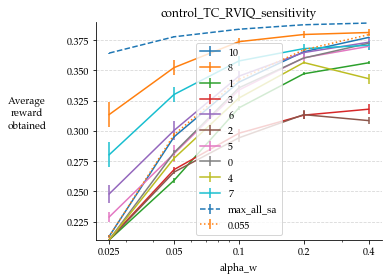

In [5]:
param_list = [
    ('./results/control/TwoLoops/', 'TwoChoice_RVIQ_eps_0.1', 'reference_state'),
    ('./results/control/TwoLoops/', 'TwoChoice_RVIQ_maxall_eps_0.1', 'f_type'),
    ('./results/control/TwoLoops/', 'TwoChoice_RVIQ_mean_eps_0.1', 'eta')
]

plot_all_tl(param_list, 'rewards_all_train', ylabel='Average\nreward\nobtained', logbase=10, 
            title='control_TC_RVIQ_sensitivity', y_lims=(0.21, 0.39), 
            out_location='./results/control/TwoLoops/',
            final=False)

Filename	eta	alpha_w	Value

0.1_18.	1	0.025	0.222	0.002
0.1_24.	2	0.025	0.222	0.002
0.1_25.	2	0.05	0.302	0.002
0.1_19.	1	0.05	0.304	0.002
_0.1_8.	0.25	0.1	0.346	0.001
0.1_27.	2	0.2	0.362	0.001
0.1_26.	2	0.1	0.343	0.001
_0.1_9.	0.25	0.2	0.368	0.001
0.1_22.	1	0.4	0.377	0.001
0.1_21.	1	0.2	0.367	0.001
0.1_20.	1	0.1	0.345	0.001
_0.1_2.	0.125	0.1	0.344	0.001
0.1_10.	0.25	0.4	0.380	0.001
_0.1_3.	0.125	0.2	0.368	0.001
_0.1_1.	0.125	0.05	0.302	0.002
0.1_12.	0.5	0.025	0.222	0.002
0.1_13.	0.5	0.05	0.304	0.002
_0.1_0.	0.125	0.025	0.217	0.002
_0.1_4.	0.125	0.4	0.380	0.001
0.1_16.	0.5	0.4	0.380	0.001
_0.1_7.	0.25	0.05	0.304	0.002
0.1_14.	0.5	0.1	0.346	0.001
0.1_28.	2	0.4	0.371	0.001
0.1_15.	0.5	0.2	0.368	0.001
_0.1_6.	0.25	0.025	0.220	0.002
dict_keys([1, 2, 0.25, 0.125, 0.5])
30
0
1
2
3
4


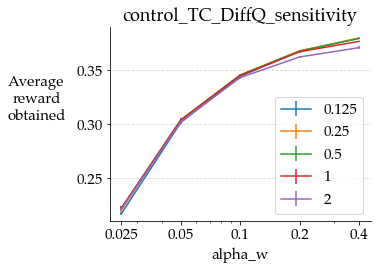

In [8]:
param_list = [
    ('./results/control/TwoLoops/', 'TwoChoice_DiffQ_eps_0.1', 'eta'),
]

plot_all_tl(param_list, 'rewards_all_train', ylabel='Average\nreward\nobtained', logbase=10, 
            title='control_TC_DiffQ_sensitivity', y_lims=(0.21, 0.39), 
            out_location='./results/control/TwoLoops/',
            final=False)

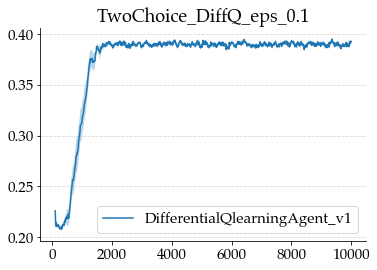

In [19]:
### These filenames will be according to how the hyperparameter configurations are split
### for the available compute resources.
filenames = [
        ('./results/control/TwoLoops/', "TwoChoice_DiffQ_eps_0.1_16.npy",)  # alpha_w=0.4, eta=0.5
    ]
    
plot_learning_curve(filenames, title='TwoChoice_DiffQ_eps_0.1', window=100,
                    sample=10, firstn=10000, out_location='./results/control/TwoLoops/', final=False)

### A3. PuckWorld

In [ ]:
### To run the experiments with Diff-Q and RVI-Q:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_PuckWorld_diff-q.json --output-folder results/control/PW
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_PuckWorld_rvi-q.json --output-folder results/control/PW

Filename	f_type	alpha_w	Value

tile_0.	max_all_sa	0.04	-0.364	0.010
tile_3.	max_all_sa	0.005	-0.349	0.002
tile_2.	max_all_sa	0.01	-0.355	0.006
ile_16.	first_s	0.0025	-0.325	0.006
ile_14.	first_s	0.01	-0.247	0.006
tile_1.	max_all_sa	0.02	-0.345	0.006
ile_13.	first_s	0.02	-0.242	0.004
tile_5.	max_all_sa	0.00125	-0.378	0.001
ile_12.	first_s	0.04	-0.311	0.011
tile_4.	max_all_sa	0.0025	-0.360	0.002
ile_15.	first_s	0.005	-0.291	0.015
ile_17.	first_s	0.00125	-0.355	0.011
dict_keys(['max_all_sa', 'first_s'])
10
0
1


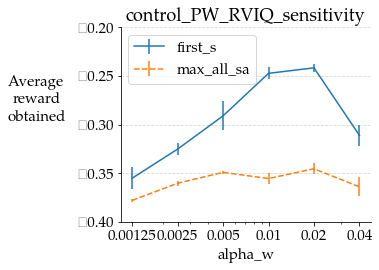

In [15]:
param_list = [
    ('./results/control/PW/', 'PW_RVIQ_eps_0.1_tile', 'f_type'),
]

plot_all_tl(param_list, 'rewards_all_train', ylabel='Average\nreward\nobtained', logbase=10, 
            title='control_PW_RVIQ_sensitivity', y_lims=(-0.4, -0.2), 
            out_location='./results/control/PW/', final=False)

Filename	eta	alpha_w	Value

tile_2.	1.0	0.01	-0.236	0.005
ile_17.	0.1	0.00125	-0.354	0.006
tile_0.	1.0	0.04	-0.220	0.000
tile_5.	1.0	0.00125	-0.338	0.009
ile_14.	0.1	0.01	-0.256	0.004
tile_7.	0.5	0.02	-0.224	0.003
tile_4.	1.0	0.0025	-0.304	0.007
ile_16.	0.1	0.0025	-0.308	0.005
ile_10.	0.5	0.0025	-0.314	0.006
ile_12.	0.1	0.04	-0.246	0.002
tile_9.	0.5	0.005	-0.283	0.008
tile_8.	0.5	0.01	-0.252	0.004
ile_15.	0.1	0.005	-0.273	0.006
ile_13.	0.1	0.02	-0.235	0.002
ile_11.	0.5	0.00125	-0.331	0.006
tile_6.	0.5	0.04	-0.231	0.001
tile_3.	1.0	0.005	-0.279	0.002
tile_1.	1.0	0.02	-0.217	0.002
dict_keys([1.0, 0.1, 0.5])
10
0
1
2


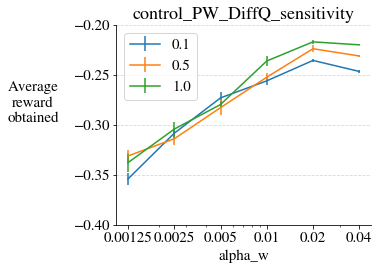

In [20]:
param_list = [
    ('./results/control/PW/', 'PW_DiffQ_eps_0.1_tile', 'eta')
]

plot_all_tl(param_list, 'rewards_all_train', ylabel='Average\nreward\nobtained', logbase=10, 
            title='control_PW_DiffQ_sensitivity', y_lims=(-0.4, -0.2), 
            out_location='./results/control/PW/', final=False)

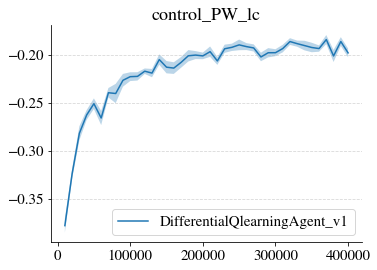

In [21]:
filenames = [
    ('./results/control/PW/', "PW_DiffQ_eps_0.1_tile_1.npy"),   # alpha=0.02, eta=1.0
]

plot_learning_curve(filenames, item='rewards_all_train', title='control_PW_lc', window=10000,
                    sample=10000, out_location='./results/control/PW/', final=False)

### A4. Catcher

In [ ]:
### To run the experiments with Diff-Q and RVI-Q:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_Catcher_diff-q.json --output-folder results/control/Catcher
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_Catcher_rvi-q_first.json --output-folder results/control/Catcher
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_Catcher_rvi-q_max_all.json --output-folder results/control/Catcher

Filename	f_type	alpha_w	Value

tile_5.	first_s	0.00125	0.386	0.023
tile_0.	first_s	0.04	0.807	0.005
tile_3.	first_s	0.005	0.752	0.012
tile_2.	first_s	0.01	0.825	0.005
tile_4.	first_s	0.0025	0.601	0.023
tile_1.	first_s	0.02	0.849	0.005
Filename	f_type	alpha_w	Value

tile_5.	max_all_sa	0.00125	0.178	0.014
tile_2.	max_all_sa	0.01	-0.054	0.033
tile_0.	max_all_sa	0.04	-0.182	0.010
tile_4.	max_all_sa	0.0025	0.274	0.043
tile_3.	max_all_sa	0.005	0.215	0.093
tile_1.	max_all_sa	0.02	-0.164	0.012
dict_keys(['first_s', 'max_all_sa'])
10
0
1


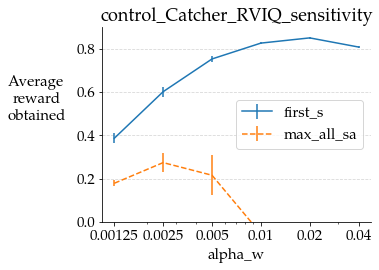

In [23]:
param_list = [
    ('./results/control/Catcher/', 'Catcher_RVIQ_first_eps_0.1_tile', 'f_type'),
    ('./results/control/Catcher/', 'Catcher_RVIQ_maxall_eps_0.1_tile', 'f_type'),
]

plot_all_tl(param_list, 'rewards_all_train', ylabel='Average\nreward\nobtained', logbase=10, 
            title='control_Catcher_RVIQ_sensitivity', y_lims=(0.0, 0.9), 
            out_location='./results/control/Catcher/', final=False)

Filename	eta	alpha_w	Value

ile_14.	0.1	0.01	0.822	0.006
tile_6.	0.5	0.04	0.807	0.003
ile_16.	0.1	0.0025	0.609	0.020
tile_0.	1.0	0.04	0.809	0.003
tile_3.	1.0	0.005	0.737	0.013
tile_5.	1.0	0.00125	0.386	0.020
ile_15.	0.1	0.005	0.752	0.013
ile_11.	0.5	0.00125	0.354	0.019
ile_13.	0.1	0.02	0.848	0.004
tile_9.	0.5	0.005	0.751	0.013
ile_12.	0.1	0.04	0.802	0.004
ile_10.	0.5	0.0025	0.569	0.028
tile_7.	0.5	0.02	0.840	0.004
tile_2.	1.0	0.01	0.818	0.012
tile_1.	1.0	0.02	0.842	0.005
tile_8.	0.5	0.01	0.843	0.008
ile_17.	0.1	0.00125	0.354	0.016
tile_4.	1.0	0.0025	0.581	0.022
dict_keys([0.1, 0.5, 1.0])
10
0
1
2


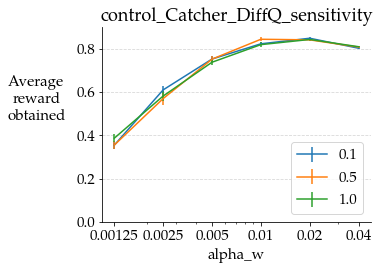

In [24]:
param_list = [
    ('./results/control/Catcher/', 'Catcher_DiffQ_eps_0.1_tile', 'eta')
]

plot_all_tl(param_list, 'rewards_all_train', ylabel='Average\nreward\nobtained', logbase=10, 
            title='control_Catcher_DiffQ_sensitivity', y_lims=(0.0, 0.9), 
            out_location='./results/control/Catcher/', final=False)

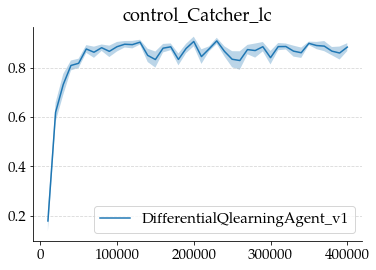

In [25]:
filenames = [
        ('./results/control/Catcher/', "Catcher_DiffQ_eps_0.1_tile_1.npy"),      # alpha=0.02, eta=1.0 
    ]

plot_learning_curve(filenames, item='rewards_all_train', title='control_Catcher_lc', window=10000,
                    sample=10000, out_location='./results/control/Catcher/', final=False)

### A5: TwoStatesOneTransient — divergence when RVI-Q's reference state is transient

In [ ]:
### To run the experiments with RVI-Q and Diff-Q:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/divergence_TwoStatesOneTrans_diff-q.json --output-folder results/control/Divergence
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/divergence_TwoStatesOneTrans_rvi-q.json --output-folder results/control/Divergence

0.008918379200000002
[0. 0. 0. ... 0. 0. 0.]
[ 8.91837920e-03  1.02882081e+01 -9.00794424e-02  1.03150545e+01]
[ 8.91837920e-03  1.02882081e+01 -9.00794424e-02  1.03150545e+01]
TwoStateTrans_RVIQ_div-test_eps_1.0_alphaw_0.01_0.npy 0.01
2.0008856283367704
[ 0.         -0.0041     -0.0045734  ...  1.0416203   1.04161441
  1.04161046]
[ 0.00891838  1.04096363 -0.09007944  1.04108306]
[-1.03269208e+00 -6.46829137e-04 -1.13168991e+00 -5.27406644e-04]
TwoStateTrans_DiffQ_div-test_eps_1.0_alphaw_0.01_0.npy 0.01


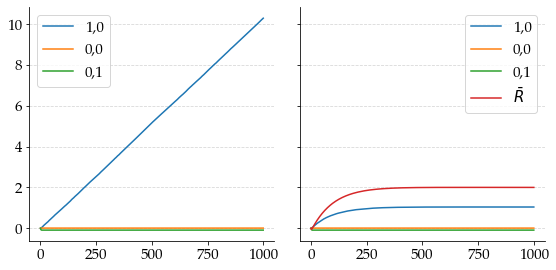

In [22]:
def plot_weights_twostatesonetrans(title, location='./results/', num_states=2,
                                   num_actions=2, which_step_size='alpha_w', final=False):

    # color_map = [['red', 'magenta', 'orange'], ['limegreen', 'cyan', 'blue']]

    filenames = ['TwoStateTrans_RVIQ_div-test_eps_1.0_alphaw_0.01_0.npy',
                 'TwoStateTrans_DiffQ_div-test_eps_1.0_alphaw_0.01_0.npy']

    fig, axes = plt.subplots(1, 2, figsize = (8,4),
                             sharey='all')

    for i, filename in enumerate(filenames):
        data = np.load(location + filename, allow_pickle=True).item()
        weights = data['weights_all']
        avg_v_all = data['avg_v_all']
        avg_r_all = data['avg_r_all']
        num_runs = avg_r_all.shape[0]
        offset = np.mean(avg_v_all, axis=0)

        print(np.mean(avg_r_all[:,-1], axis=0))
        print(offset)
        x_s = np.arange(avg_v_all.shape[1]) * data['params']['exp_parameters']['eval_every_n_steps']

        print(np.mean(weights[:,-1,:], axis=0))
        print(np.mean(weights[:,-1,:], axis=0) - offset[-1])

        mean = np.mean(weights[:,:,1], axis=0)
        stderr = np.std(weights[:,:,1], axis=0) / np.sqrt(num_runs)
        axes[i].plot(x_s, mean, label='1,0')
        axes[i].fill_between(x_s, mean + stderr, mean - stderr, alpha=0.3)
        
        mean = np.mean(weights[:,:,0], axis=0)
        stderr = np.std(weights[:,:,0], axis=0) / np.sqrt(num_runs)
        axes[i].plot(x_s, mean, label='0,0')
        axes[i].fill_between(x_s, mean + stderr, mean - stderr, alpha=0.3)
        
        mean = np.mean(weights[:,:,2], axis=0)
        stderr = np.std(weights[:,:,2], axis=0) / np.sqrt(num_runs)
        axes[i].plot(x_s, mean, label='0,1')
        axes[i].fill_between(x_s, mean + stderr, mean - stderr, alpha=0.3)
        
        if 'DiffQ' in filename:
            mean = np.mean(avg_r_all, axis=0)
            stderr = np.std(avg_r_all, axis=0) / np.sqrt(num_runs)
            axes[i].plot(x_s, mean, label=r'$\bar{R}$')
            axes[i].fill_between(x_s, mean + stderr, mean - stderr, alpha=0.3)

        ss = data['params']['agent_parameters'][which_step_size]
        if not final:
            print(filename, ss)
            axes[i].legend()
        axes[i].grid(b=True, axis='y', alpha=0.5, linestyle='--')

    plt.tight_layout()
    if final:
        assert os.path.isfile(location + title + '_weights.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(location + title + '_weights.png', dpi=1200, transparent=True)
    plt.show()
    
plot_weights_twostatesonetrans('TwoStateTrans_div_eps1.0_alphaw_0.01_withR', location='./results/control/Divergence',
                               final=False)

## B. Prediction

### B1. TwoLoop

Filename	eta	alpha_w	Value

fTD_21.	1	0.2	0.048	0.000
fTD_20.	1	0.1	0.050	0.000
fTD_22.	1	0.4	0.059	0.000
ffTD_3.	0.125	0.025	0.252	0.002
fTD_23.	2	0.025	0.252	0.001
ffTD_7.	0.125	0.4	0.051	0.000
ffTD_6.	0.125	0.2	0.039	0.000
fTD_26.	2	0.2	0.075	0.000
fTD_32.	2	0.4	0.094	0.000
fTD_18.	1	0.025	0.252	0.001
fTD_24.	2	0.05	0.096	0.000
ffTD_4.	0.125	0.05	0.077	0.001
ffTD_5.	0.125	0.1	0.043	0.000
fTD_25.	2	0.1	0.069	0.000
fTD_19.	1	0.05	0.085	0.000
fTD_14.	0.5	0.05	0.080	0.000
ffTD_8.	0.25	0.025	0.253	0.001
ffTD_9.	0.25	0.05	0.078	0.001
fTD_15.	0.5	0.1	0.042	0.000
fTD_17.	0.5	0.4	0.039	0.000
fTD_16.	0.5	0.2	0.035	0.000
fTD_12.	0.25	0.4	0.041	0.000
fTD_13.	0.5	0.025	0.253	0.001
fTD_11.	0.25	0.2	0.035	0.000
fTD_10.	0.25	0.1	0.042	0.000
dict_keys([1, 0.125, 2, 0.5, 0.25])
30
0
1
2
3
4


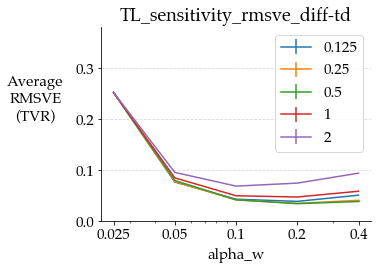

Filename	eta	alpha_w	Value

fTD_21.	1	0.2	0.001	0.000
fTD_20.	1	0.1	0.001	0.000
fTD_22.	1	0.4	0.002	0.000
ffTD_3.	0.125	0.025	0.002	0.000
fTD_23.	2	0.025	0.000	0.000
ffTD_7.	0.125	0.4	0.000	0.000
ffTD_6.	0.125	0.2	0.000	0.000
fTD_26.	2	0.2	0.002	0.000
fTD_32.	2	0.4	0.004	0.000
fTD_18.	1	0.025	0.000	0.000
fTD_24.	2	0.05	0.001	0.000
ffTD_4.	0.125	0.05	0.001	0.000
ffTD_5.	0.125	0.1	0.000	0.000
fTD_25.	2	0.1	0.001	0.000
fTD_19.	1	0.05	0.000	0.000
fTD_14.	0.5	0.05	0.000	0.000
ffTD_8.	0.25	0.025	0.001	0.000
ffTD_9.	0.25	0.05	0.000	0.000
fTD_15.	0.5	0.1	0.000	0.000
fTD_17.	0.5	0.4	0.001	0.000
fTD_16.	0.5	0.2	0.001	0.000
fTD_12.	0.25	0.4	0.001	0.000
fTD_13.	0.5	0.025	0.000	0.000
fTD_11.	0.25	0.2	0.000	0.000
fTD_10.	0.25	0.1	0.000	0.000
dict_keys([1, 0.125, 2, 0.5, 0.25])
30
0
1
2
3
4


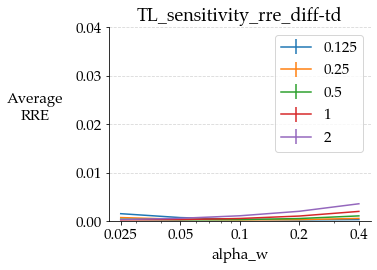

In [36]:
param_list = [
    ('./results/prediction/TL/', 'TwoLoop_decay_DiffTD', 'eta'),
]

plot_all_tl(param_list, 'rmsve_tvr_all', ylabel='Average\nRMSVE\n(TVR)', logbase=10, y_lims=(0.0, 0.38), 
            out_location='results/prediction/TL/', title='TL_sensitivity_rmsve_diff-td', final=False)
plot_all_tl(param_list, 'rre_all', ylabel='Average\nRRE', logbase=10, y_lims=(0.0, 0.04), 
            out_location='results/prediction/TL/', title='TL_sensitivity_rre_diff-td', final=False)

Filename	eta	alpha_w	Value

tTD_15.	0.5	0.1	0.054	0.000
tTD_14.	0.5	0.05	0.072	0.000
stTD_3.	0.125	0.025	0.251	0.002
tTD_16.	0.5	0.2	0.067	0.000
tTD_17.	0.5	0.4	0.120	0.000
stTD_4.	0.125	0.05	0.075	0.001
tTD_13.	0.5	0.025	0.247	0.001
tTD_12.	0.25	0.4	0.095	0.000
stTD_5.	0.125	0.1	0.047	0.000
stTD_7.	0.125	0.4	0.081	0.001
tTD_10.	0.25	0.1	0.049	0.000
tTD_11.	0.25	0.2	0.055	0.000
stTD_6.	0.125	0.2	0.050	0.000
tTD_20.	1	0.1	0.065	0.000
tTD_21.	1	0.2	0.090	0.000
stTD_8.	0.25	0.025	0.250	0.002
tTD_23.	2	0.025	0.231	0.001
tTD_22.	1	0.4	0.160	0.001
stTD_9.	0.25	0.05	0.073	0.001
tTD_26.	2	0.2	0.127	0.000
tTD_32.	2	0.4	0.207	0.001
tTD_25.	2	0.1	0.087	0.000
tTD_19.	1	0.05	0.073	0.000
tTD_18.	1	0.025	0.242	0.001
tTD_24.	2	0.05	0.079	0.000
dict_keys([0.5, 0.25, 0.125, 1, 2])
30
0
1
2
3
4


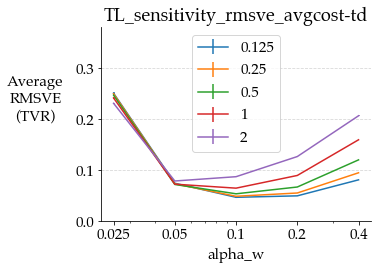

Filename	eta	alpha_w	Value

tTD_15.	0.5	0.1	0.000	0.000
tTD_14.	0.5	0.05	0.000	0.000
stTD_3.	0.125	0.025	0.002	0.000
tTD_16.	0.5	0.2	0.001	0.000
tTD_17.	0.5	0.4	0.003	0.000
stTD_4.	0.125	0.05	0.001	0.000
tTD_13.	0.5	0.025	0.000	0.000
tTD_12.	0.25	0.4	0.001	0.000
stTD_5.	0.125	0.1	0.000	0.000
stTD_7.	0.125	0.4	0.000	0.000
tTD_10.	0.25	0.1	0.000	0.000
tTD_11.	0.25	0.2	0.000	0.000
stTD_6.	0.125	0.2	0.000	0.000
tTD_20.	1	0.1	0.001	0.000
tTD_21.	1	0.2	0.003	0.000
stTD_8.	0.25	0.025	0.001	0.000
tTD_23.	2	0.025	0.000	0.000
tTD_22.	1	0.4	0.009	0.000
stTD_9.	0.25	0.05	0.000	0.000
tTD_26.	2	0.2	0.009	0.000
tTD_32.	2	0.4	0.031	0.000
tTD_25.	2	0.1	0.003	0.000
tTD_19.	1	0.05	0.000	0.000
tTD_18.	1	0.025	0.000	0.000
tTD_24.	2	0.05	0.001	0.000
dict_keys([0.5, 0.25, 0.125, 1, 2])
30
0
1
2
3
4


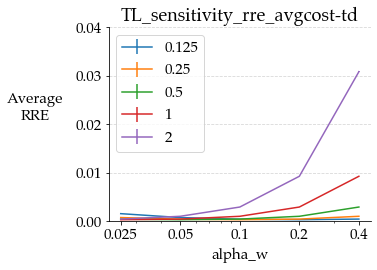

In [37]:
param_list = [
    ('./results/prediction/TL/', 'TwoLoop_decay_AvgCostTD', 'eta'),
]

plot_all_tl(param_list, 'rmsve_tvr_all', ylabel='Average\nRMSVE\n(TVR)', logbase=10, y_lims=(0.0, 0.38), 
            out_location='results/prediction/TL/', title='TL_sensitivity_rmsve_avgcost-td', final=False)
plot_all_tl(param_list, 'rre_all', ylabel='Average\nRRE', logbase=10, y_lims=(0.0, 0.04), 
            out_location='results/prediction/TL/', title='TL_sensitivity_rre_avgcost-td', final=False)

Filename	eta	alpha_w	Value

fTD_15.	0.5	0.1	0.188	0.007
fTD_14.	0.5	0.05	0.445	0.007
fTD_16.	0.5	0.2	0.085	0.002
fTD_17.	0.5	0.4	0.081	0.001
fTD_13.	0.5	0.025	0.660	0.005
ffTD_8.	0.25	0.025	0.681	0.005
ffTD_9.	0.25	0.05	0.468	0.008
fTD_12.	0.25	0.4	0.100	0.001
fTD_10.	0.25	0.1	0.202	0.008
fTD_11.	0.25	0.2	0.089	0.002
fTD_20.	1	0.1	0.183	0.006
ffTD_7.	0.125	0.4	0.147	0.002
ffTD_6.	0.125	0.2	0.101	0.002
fTD_21.	1	0.2	0.113	0.001
fTD_23.	2	0.025	0.629	0.005
ffTD_4.	0.125	0.05	0.500	0.008
ffTD_5.	0.125	0.1	0.227	0.008
fTD_22.	1	0.4	0.120	0.001
fTD_32.	2	0.4	0.696	0.191
fTD_26.	2	0.2	0.156	0.001
fTD_19.	1	0.05	0.425	0.007
fTD_25.	2	0.1	0.193	0.004
ffTD_3.	0.125	0.025	0.715	0.005
fTD_24.	2	0.05	0.402	0.007
fTD_18.	1	0.025	0.645	0.005
dict_keys([0.5, 0.25, 1, 0.125, 2])
30
0
1
2
3
4


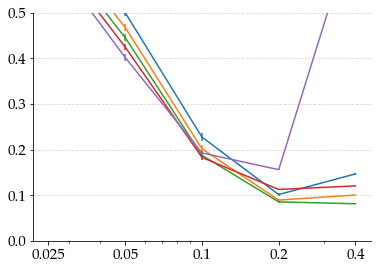

Filename	eta	alpha_w	Value

fTD_15.	0.5	0.1	0.004	0.000
fTD_14.	0.5	0.05	0.011	0.000
fTD_16.	0.5	0.2	0.002	0.000
fTD_17.	0.5	0.4	0.003	0.000
fTD_13.	0.5	0.025	0.018	0.000
ffTD_8.	0.25	0.025	0.020	0.000
ffTD_9.	0.25	0.05	0.013	0.000
fTD_12.	0.25	0.4	0.002	0.000
fTD_10.	0.25	0.1	0.004	0.000
fTD_11.	0.25	0.2	0.002	0.000
fTD_20.	1	0.1	0.003	0.000
ffTD_7.	0.125	0.4	0.002	0.000
ffTD_6.	0.125	0.2	0.002	0.000
fTD_21.	1	0.2	0.003	0.000
fTD_23.	2	0.025	0.015	0.000
ffTD_4.	0.125	0.05	0.016	0.000
ffTD_5.	0.125	0.1	0.006	0.000
fTD_22.	1	0.4	0.006	0.002
fTD_32.	2	0.4	106.199	59.241
fTD_26.	2	0.2	0.004	0.000
fTD_19.	1	0.05	0.010	0.000
fTD_25.	2	0.1	0.004	0.000
ffTD_3.	0.125	0.025	0.023	0.000
fTD_24.	2	0.05	0.009	0.000
fTD_18.	1	0.025	0.016	0.000
dict_keys([0.5, 0.25, 1, 0.125, 2])
30
0
1
2
3
4


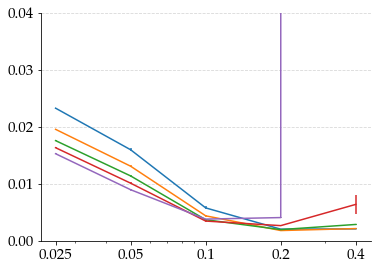

In [28]:
param_list = [
    ('./results/prediction/TL/', 'TwoLoop_off_0.9_decay_DiffTD', 'eta'),
]

plot_all_tl(param_list, 'rmsve_tvr_all', ylabel='Average\nRMSVE\n(TVR)', logbase=10, y_lims=(0.0, 0.5), 
            out_location='results/prediction/TL/', title='TL_sensitivity_rmsve_diff-td-off', final=True)
plot_all_tl(param_list, 'rre_all', ylabel='Average\nRRE', logbase=10, y_lims=(0.0, 0.04), 
            out_location='results/prediction/TL/', title='TL_sensitivity_rre_diff-td-off', final=True)

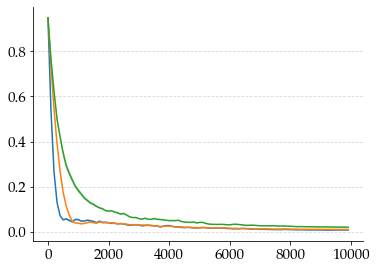

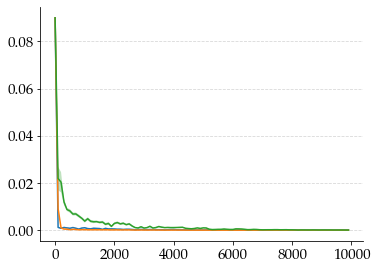

In [40]:
filenames = [
    ('results/prediction/TL/', "TwoLoop_decay_DiffTD_11.npy"),     # alpha=0.2, eta=0.25 (best auc)
    ('results/prediction/TL/', "TwoLoop_decay_AvgCostTD_5.npy"),   # alpha=0.1, eta=0.125 (best auc)
    ('results/prediction/TL/', "TwoLoop_off_0.9_decay_DiffTD_16.npy"),    # alpha=0.2, eta=0.5 (best asymptotic)
]

plot_learning_curve(filenames, item='rmsve_tvr_all', window=1, sample=100, 
                    title='TL_lc_rmsve', out_location='results/prediction/TL/', final=False)
plot_learning_curve(filenames, item='rre_all', window=1, sample=100, 
                    title='TL_lc_rre', out_location='results/prediction/TL/', final=False)

## Centering

### Two Loop

In [3]:
### To run the experiments with centered Differential Q-learning:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/centering_TC_diff-q.json --output-folder results/centering/TwoLoops

In [17]:
def get_centered_values(env, policy):
    with open("environments/centered_values.json") as f:
        centered_values_all = json.load(f)
    try:
        centered_values = centered_values_all[env][policy]
    except:
        print("Something went wrong. Have the centered_values for this policy in this environment not saved"
              "in environments/centered_values.json?")
        raise

    return centered_values

def parse_data_rmsve(filename_prefix, domain, policy, location='../results/', param1='eta_f', param2='alpha_w_f',
               title=None, firstn=-1, num_sa=None, logbase=-1, ylabel='RMSVE', final=False):

    centered_values = get_centered_values(domain, policy)
    target = centered_values["q_pi"]
    dist_sa = centered_values["d_pi_sa"]

    files = all_files_with_prefix_and_suffix(location, filename_prefix, '*.npy')
    data_all = {}
    assert len(files) > 0, 'No files found with the prefix: ' + location + filename_prefix
    print('Filename\t%s\t%s\tAUC\tAsymMean\tAsymStderr\n' % (param1, param2))

    for file in files:
        data = np.load(file, allow_pickle=True).item()
        param1_value = data['params']['agent_parameters'][param1]
        if param1_value not in data_all:
            data_all[param1_value] = {}
        param2_value = data['params']['agent_parameters'][param2] if param2!='dummy' else -1
        if param2_value in [0.8]:
            continue
        if param2_value not in data_all[param1_value]:
            data_all[param1_value][param2_value] = {}

        weights_all = data['weights_all'][:,:firstn]
        avg_v_all = data['avg_v_all'][:,:firstn]
        num_runs = weights_all.shape[0]
        num_eval_steps = weights_all.shape[1]
        weights = weights_all
        offsets = avg_v_all
        rmsve = np.zeros((num_runs, num_eval_steps))

        for i in range(num_runs):
            for j in range(num_eval_steps):
                final_weights = weights[i,j,:]-offsets[i][j]
                try:
                    rmsve[i][j] = np.sqrt(np.dot((target - final_weights)**2, dist_sa))
                except:
                    rmsve[i][j] = np.nan

        rmsve_auc = np.mean(rmsve)
        rmsve_asymptotic = np.mean(rmsve[:,num_eval_steps//2:], axis=1)
        rmsve_asymptotic_mean = np.mean(rmsve_asymptotic)
        rmsve_asymptotic_stderr = np.std(rmsve_asymptotic) / np.sqrt(num_runs)

        alpha_w_f = data['params']['agent_parameters']['alpha_w_f']
        eta_f = data['params']['agent_parameters']['eta_f']
        data_all[param1_value][param2_value] = (rmsve_asymptotic_mean, rmsve_asymptotic_stderr)

        print('%s\t%s\t%s\t%.3f\t%.3f\t%.3f' % (file[-6:-4], param1_value, param2_value,
                                                rmsve_auc, rmsve_asymptotic_mean, rmsve_asymptotic_stderr))

    X = sorted(data_all)
    Y = sorted(data_all[np.random.choice(list(data_all.keys()))])
    Z_mean = np.zeros((len(X), len(Y)))
    Z_stderr = np.zeros((len(X), len(Y)))
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            try:
                Z_mean[i][j] = data_all[x][y][0]
                Z_stderr[i][j] = data_all[x][y][1]
            except:
                Z_mean[i][j] = np.nan
                Z_stderr[i][j] = np.nan
    Z_mean = np.ma.masked_invalid(Z_mean)
    Z_stderr = np.ma.masked_invalid(Z_stderr)

    fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

    for i, param_value in enumerate(X):
        ax.errorbar(Y, Z_mean[i], yerr=Z_stderr[i], label=param1+'='+str(param_value))#, color='color')
    ax.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    if not final:
        plt.xlabel(param2)
        plt.ylabel(ylabel, rotation=0, labelpad=40)
        ax.set_title(title)
        ax.legend()
    #plt.ylim(0.0, 0.8)
    if logbase != -1:
        plt.xscale('log', basex=logbase)
    ax.set_xticks(Y)
    ax.set_xticklabels(Y)

    fig.tight_layout()
    if final:
        assert os.path.isfile(location + title + '.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(location + title + '.png', dpi=1200, transparent=True)
    plt.show()

def get_rmsve_data_lc(filename, domain, policy, firstn=-1):

    centered_values = get_centered_values(domain, policy)
    target = centered_values["q_pi"]
    dist_sa = centered_values["d_pi_sa"]

    data = np.load(filename, allow_pickle=True).item()
    weights_all = data['weights_all'][:,:firstn]
    avg_v_all = data['avg_v_all'][:,:firstn]
    num_runs = weights_all.shape[0]
    num_eval_steps = weights_all.shape[1]
    weights = weights_all
    offsets = avg_v_all
    rmsve = np.zeros((num_runs, num_eval_steps))

    for i in range(num_runs):
        for j in range(num_eval_steps):
            final_weights = weights[i,j,:]-offsets[i][j]
            rmsve[i][j] = np.sqrt(np.dot((target - final_weights)**2, dist_sa))

    mean_rmsve = np.mean(rmsve, axis=0)
    stderr_rmsve = np.std(rmsve, axis=0) / np.sqrt(num_runs)

    #print(np.mean(weights[:,-1,:], axis=0))
    #print(np.mean(offsets[:,-1]))
    #print(np.mean(weights[:,-1,:], axis=0) - np.mean(offsets[:,-1]))
    agent_name = data['params']['agent']
    alpha_w = data['params']['agent_parameters']['alpha_w']
    #print(filename)

    params = {'agent': agent_name, 'alpha_w': alpha_w}
    if 'alpha_r' in data['params']['agent_parameters']:
        params['alpha_r'] = data['params']['agent_parameters']['alpha_r']
    if 'alpha_w_f' in data['params']['agent_parameters']:
        params['alpha_w_f'] = data['params']['agent_parameters']['alpha_w_f']
    print(params)
    x_s = np.arange(num_eval_steps) * data['params']['exp_parameters']['eval_every_n_steps']
    reward_rate_train = data['rewards_all_train']
    reward_rate_train_lasthalf = np.mean(reward_rate_train[:,reward_rate_train.shape[1]//2:])
    return params, x_s, mean_rmsve, stderr_rmsve, reward_rate_train_lasthalf

def plot_learning_curve_rmsve(filenames, domain, policy, location='./results/', title=None, sample=1, firstn=-1,
                              final=False):

    fig, ax = plt.subplots(1, 1, figsize=(5.5,4))
    
    for file in filenames:
        params, x_s, mean_rmsve, stderr_rmsve, _ = get_rmsve_data_lc(location + file, domain, policy, firstn)
        x_s = x_s[::sample]
        mean_rmsve = mean_rmsve[::sample]
        stderr_rmsve = stderr_rmsve[::sample]
        plt.plot(x_s, mean_rmsve, label=params['agent'])
        plt.fill_between(x_s, mean_rmsve + stderr_rmsve, mean_rmsve - stderr_rmsve, alpha=0.3)
        # plot_data[step_size] = (max_msve, 0) if average_msve >= max_msve else (average_msve, stderr_msve)

    if not final:
        plt.legend()
        plt.ylabel('RMSVE\nduring training', rotation=0, labelpad=70)
        plt.xlabel('Timesteps')
    plt.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    # plt.axhline(y=0.0, color='black', alpha=0.7, linestyle='--')
    plt.ylim(-0.1, 3.0)
    plt.tight_layout()
    if final:
        assert os.path.isfile(location + title + '.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(location + title + '.png', dpi=1200, transparent=True)
    plt.show()

Filename	eta_f	alpha_w_f	AUC	AsymMean	AsymStderr

_9	1	0.025	0.128	0.057	0.001
_8	0.5	0.1	0.098	0.011	0.000
12	2	0.025	0.134	0.062	0.001
13	2	0.05	0.125	0.043	0.001
11	1	0.1	0.105	0.016	0.000
10	1	0.05	0.118	0.037	0.001
28	2	0.4	0.105	0.010	0.000
14	2	0.1	0.114	0.024	0.001
15	0.125	0.2	0.083	0.001	0.000
16	0.125	0.4	0.082	0.000	0.000
27	2	0.2	0.106	0.014	0.000
24	1	0.2	0.096	0.006	0.000
18	0.25	0.2	0.086	0.001	0.000
19	0.25	0.4	0.084	0.001	0.000
25	1	0.4	0.092	0.003	0.000
21	0.5	0.2	0.090	0.002	0.000
22	0.5	0.4	0.087	0.001	0.000
_0	0.125	0.025	0.127	0.047	0.001
_1	0.125	0.05	0.101	0.023	0.001
_3	0.25	0.025	0.122	0.050	0.001
_2	0.125	0.1	0.087	0.005	0.000
_6	0.5	0.025	0.124	0.053	0.001
_7	0.5	0.05	0.111	0.032	0.001
_5	0.25	0.1	0.092	0.007	0.000
_4	0.25	0.05	0.105	0.027	0.001


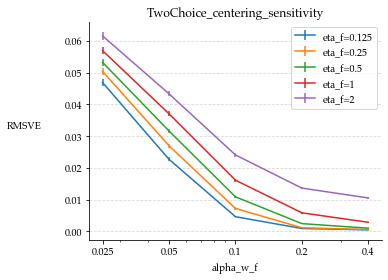

In [13]:
parse_data_rmsve('TwoChoice_DiffQ_eps_0.1_alpha_0.4_eta_0.5', domain="TwoChoiceMDP", policy="0.0",
                 param1='eta_f', param2='alpha_w_f', 
                 title='TwoChoice_centering_sensitivity', firstn=-1, logbase=10,
                 location='./results/centering/TwoLoops/', final=False)

{'agent': 'RVIQlearningAgent', 'alpha_w': 0.4}
{'agent': 'DifferentialQlearningAgent_v1', 'alpha_w': 0.4, 'alpha_w_f': 0.0}
{'agent': 'DifferentialQlearningAgent_v1', 'alpha_w': 0.4, 'alpha_w_f': 0.4}


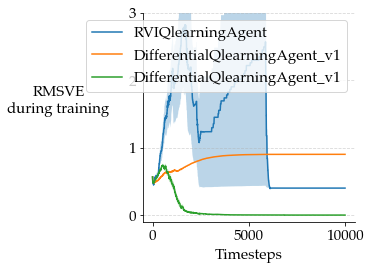

In [18]:
filenames = [
        "TwoChoice_RVIQ_eps_0.1_52.npy", # alpha=0.4, ref_state=8
        "TwoChoice_DiffQ_eps_0.1_16.npy", # alpha=0.4, eta=0.5
        "TwoChoice_DiffQ_eps_0.1_alpha_0.4_eta_0.5_16.npy" # alpha=0.4, eta=0.5, alpha_f=0.4, eta_f=0.125
    ]

plot_learning_curve_rmsve(filenames, "TwoChoiceMDP", "0.0", location='./results/centering/TwoLoops',
                          title='TwoChoice_centering_rmsve_lc', sample=1, firstn=10000, final=False)